## Importing Libraries

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import urllib.request

## Importing Dataset

In [2]:
def load_house_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(exist_ok=True, parents=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as tarball:
            tarball.extractall(path="datasets")
    return pd.read_csv("datasets/housing/housing.csv")

housing = load_house_data()

## Reviewing Dataset

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

`total_bedrooms` has missing values. We will fill them with the median value. <br>
`ocean_proximity` is a categorical variable. We will use one-hot encoding to convert it into numerical values.

## Draw histogram for each numerical attribute

In [6]:
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

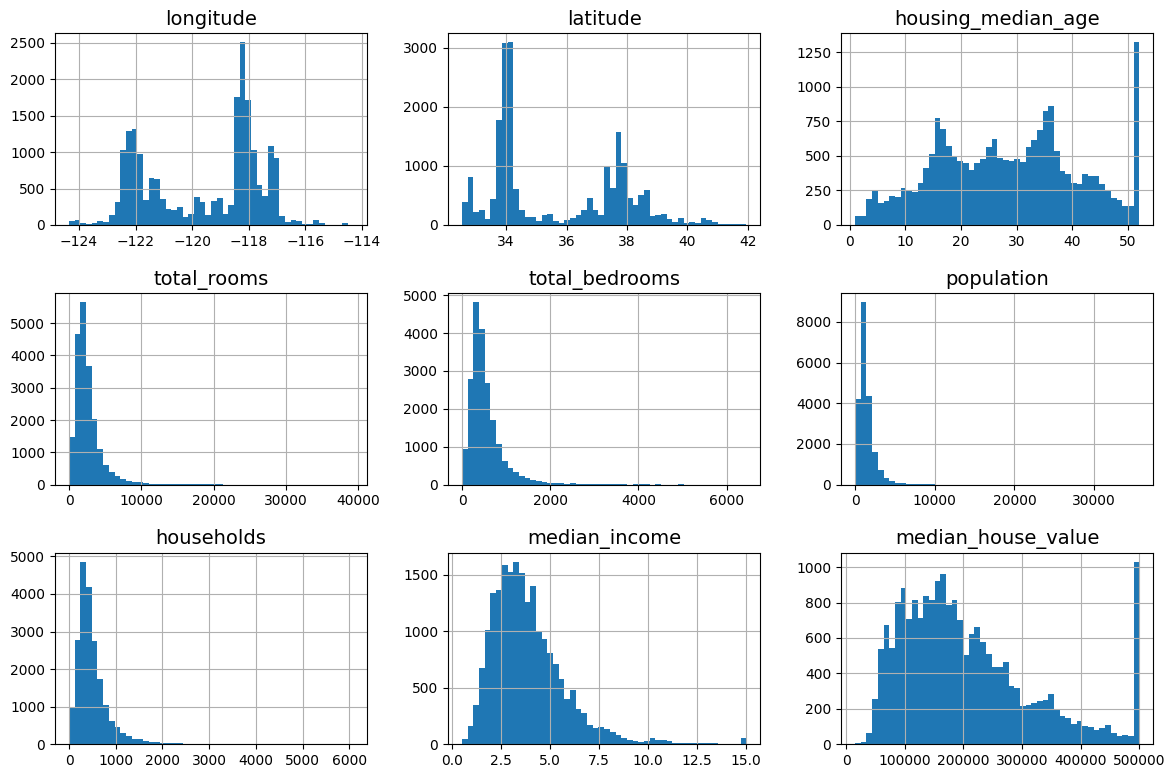

In [7]:
# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

## Splitting the dataset into training and testing set

In [8]:
np.random.seed(42)
def shuffle_and_split_data(data, test_radio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_radio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = shuffle_and_split_data(housing, 0.2)

Sadly, this won't guarantee that this notebook will output exactly the same results as in the book, since there are other possible sources of variation. The most important is the fact that algorithms get tweaked over time when libraries evolve. So please tolerate some minor differences: hopefully, most of the outputs should be the same, or at least in the right ballpark. <br>


In [9]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set] 
    # Toán tử ~ dùng để đảo ngược các giá trị trong in_test_set, nghĩa là True sẽ trở thành False và ngược lại.

Unfortunately, the housing dataset does not have an identifier column. The simplest solution is to use the row index as the ID:

In [10]:
housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

If you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset, and no row ever gets deleted. If this is not possible, then you can try to build a unique identifier by combining some stable features, such as the district’s latitude and longitude. <br>
For example, a district’s latitude and longitude are guaranteed to be stable for a few million years, so you could build the ID like this:

In [11]:
housing_with_id["id"] = housing_with_id["longitude"] * 1000 + housing_with_id["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

Or you can use "train_test_split" function from sklearn to split the dataset into training and testing set. <br>

In [12]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

## Create new attributes to improve the test set

### Draw histogram for income category

The following code uses the `pd.cut()` function to create an income category attribute with five categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on:

In [13]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

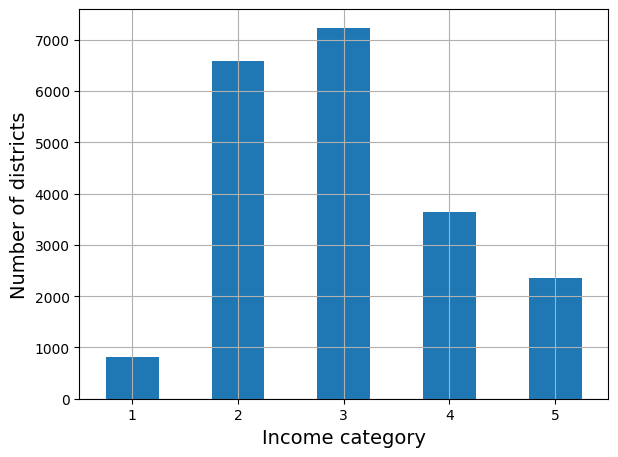

In [14]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
save_fig("housing_income_cat_bar_plot")  # extra code
plt.show()

The following code generates 10 different stratified splits of the same dataset:

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])
    
# You cab use the first stratified split for your training set and test set
strat_train_set, strat_test_set = strat_splits[0]

It's much shorter to get a single stratified split:

In [16]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

Comparing the income category proportions in the overall dataset, in the test set generated with `stratified sampling`, and in a test set generated using purely `random sampling`. As you can see, the `stratified sampling` produces test sets that are **much more representative** of the overall population.

In [17]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


You won't use the `income_cat` attribute anymore, so let's drop it:

In [18]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Explore and visualize the data to gain insights

- You're going to experiment with various transformations of the full training set, you should work on a copy of the strat_train_set so you can revert to it afterwards:

In [19]:
housing = strat_train_set.copy()

### Visualizing Geographical Data
- Because the dataset includes geographical information (latitude and longitude), it is a good idea to create a scatterplot of all districts to visualize the data

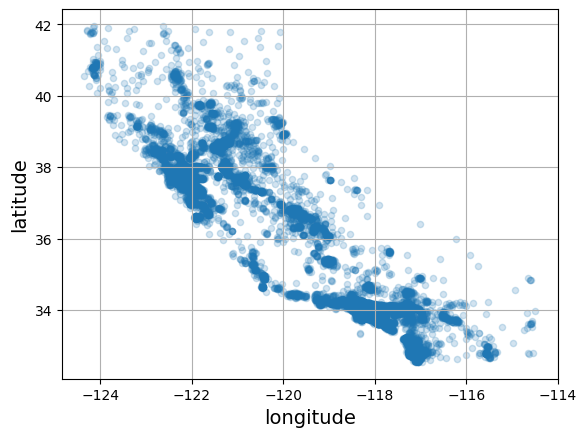

In [20]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=0.2)
plt.show()

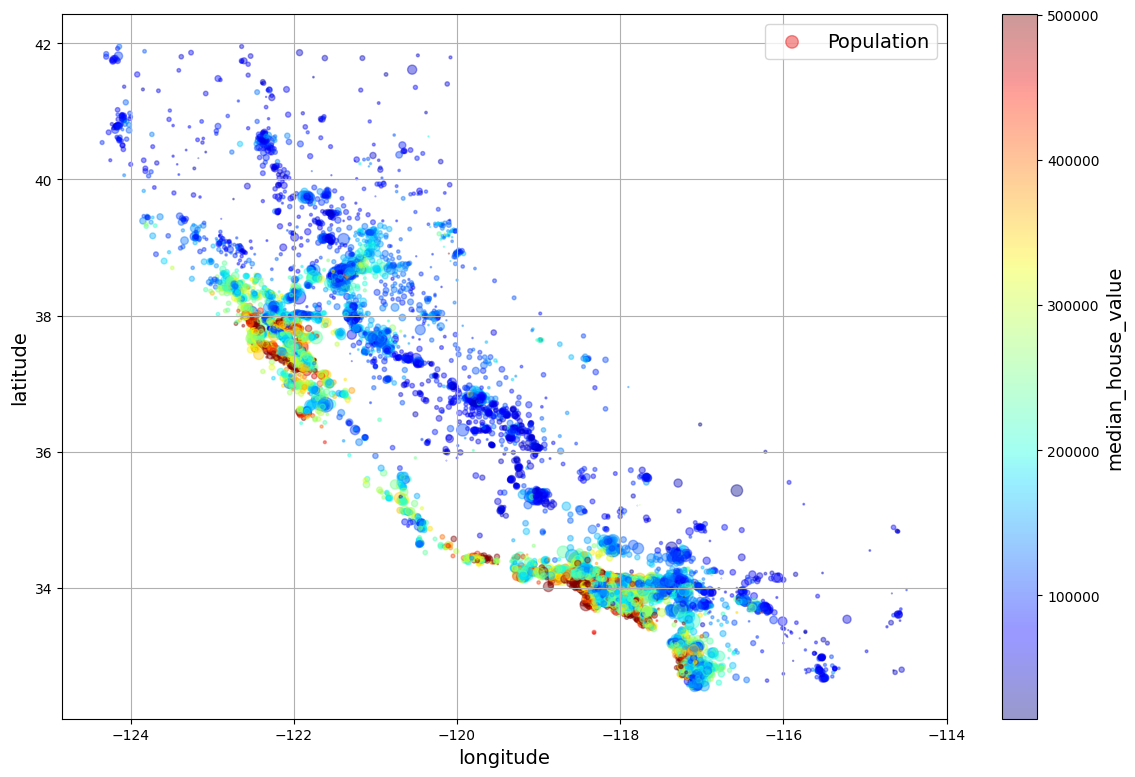

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"]/100, label="Population",
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             alpha=0.4, figsize=(12,8))
save_fig("housing_prices_scatterplot")  # extra code
plt.show()

- This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density, as you probably knew already. A clustering algorithm should be useful for detecting the main cluster and for adding new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

### Look for Correlations

In [22]:
corr_matrix = housing.drop("ocean_proximity", axis=1).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

- Use the `pandas scatter_matrix()`, which plots every numerical attribute againstevery other numerical attribute.

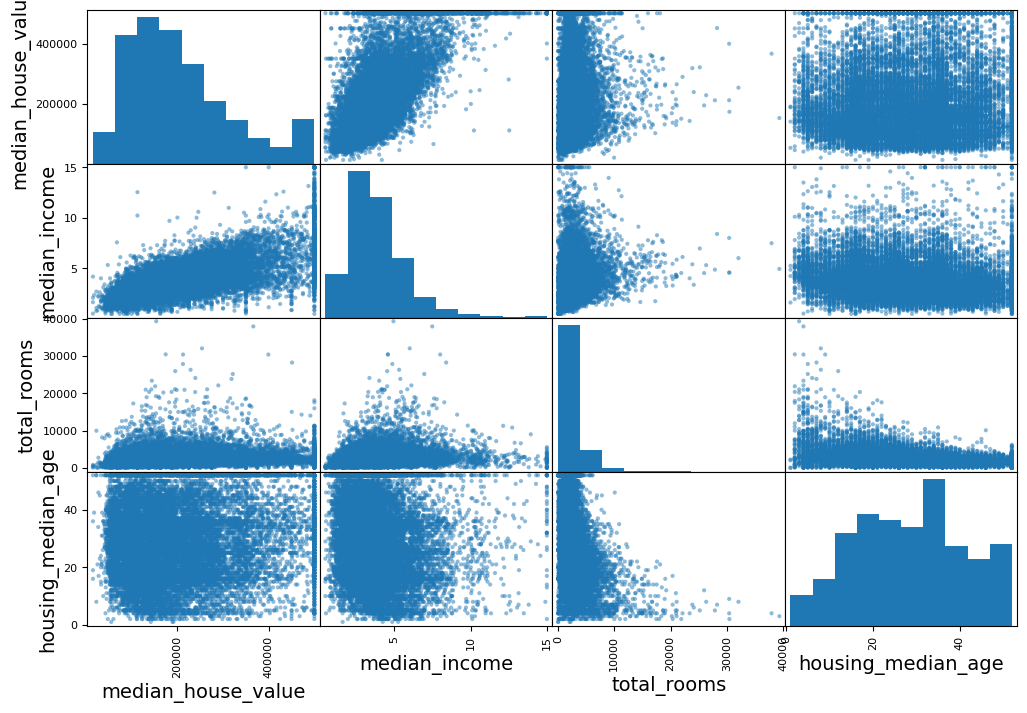

In [23]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

- The main diagonal would be full of straight lines if Pandas plotted each variable against itself, which would not be very useful. So instead Pandas displays a histogram of each attribute.
- It seems like the most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot.

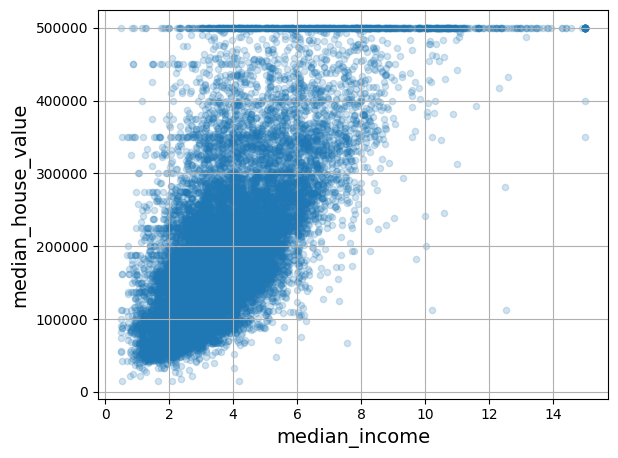

In [24]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.2, grid=True)
save_fig("income_vs_house_value_scatterplot")  # extra code
plt.show()

### Experimenting with Attribute Combinations
- The total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. Let’s create these new attributes:

In [25]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["people_per_house"] = housing["population"]/housing["households"]


In [26]:
corr_matrix = housing.drop("ocean_proximity", axis=1).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.688380
rooms_per_household    0.143663
total_rooms            0.137455
housing_median_age     0.102175
households             0.071426
total_bedrooms         0.054635
population            -0.020153
people_per_house      -0.038224
longitude             -0.050859
latitude              -0.139584
bedrooms_ratio        -0.256397
Name: median_house_value, dtype: float64

- The new `bedrooms_ratio` is much more correlated with the median house value than the total number of rooms or bedrooms. 
- The number of rooms per household is also more informative than the total number of rooms in a district — obviously the larger the houses, the more expensive they are.

## Prepare the data for Machine Learning algorithms

In [27]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Clean the data
- Remember that `total_bedrooms` has some missing values, there are 3 ways to fix this:
    - Get rid of the corresponding districts.
    - Get rid of the whole attribute.
    - Set the values to some value (zero, the mean, the median, etc.). This is called `Imputation`. <br>
=> We will choose `option 3`

In [28]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

- Because the median can only be computed on numerical attributes, we need to create a copy of the data without the text attribute `ocean_proximity`:

In [29]:
housing_num = housing.select_dtypes(include=[np.number])

In [30]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [47]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

- Now you can use this `trained` imputer to transform the training set by replacing missing values by the learned medians:

In [31]:
X = imputer.transform(housing_num)

- There are another 2 strategies, **support non-numerical attributes**:
    - With the most frequent value `strategy="most_frequent"`
    - With a constant value `strategy="constant", fill_value=...`

- There are also more powerful imputers available in the `sklearn.imputer`:
    - `KNNImputer` replaces missing values by the mean value of the `K` nearest neighbors. The distance is based on all available features. <br>
    - `IterativeImputer` trains a regression model per feature to predict the missing values based on all the other available features. It then trains the model again on the updated data, and repeats the process several time, improving the models and the replacement values at each iteration.<br>

In [48]:
# convert X back to a Pandas DataFrame
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


- Now lets drop some outliers

In [33]:
from sklearn.ensemble import IsolationForest
isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [34]:
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

In [35]:
housing = housing.iloc[outlier_pred == 1]
housing_labels = housing_labels.iloc[outlier_pred == 1]

### Handling text and categorical attributes

In [36]:
housing_cat= housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN


In [37]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

- One issue with this representation is that ML algorithms will assume that two nearby value are more similar than two distant values. In this case, it's not good for the `ocean_proximity` column because categories 0 and 4 are clearly more similar than categories 0 and 1. To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is "<1H OCEAN" (and 0 otherwise), another attribute equal to 1 when the category is "INLAND" (and 0 otherwise), and so on. This is called **one-hot encoding**, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).

In [38]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [39]:
housing_cat_encoded[:8]

array([[0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.]])

In [40]:

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [41]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [42]:
housing_cat_1hot.toarray()[:8]

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]])

- If you prefer, you can set the `handle_unknown` hyperparameter to `ignore`, in which case it will just represent the unknown category with zeros

In [43]:
cat_encoder.handle_unknown = 'ignore'

In [44]:
df_test = pd.DataFrame({'ocean_proximity': ['<2h OCEAN', 'INLAND', 'ISLAND']})
test = cat_encoder.transform(df_test)
test.toarray()

array([[0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

- When you fit any Scikit-Learn estimator using a `DataFrame`, the estimator stores the column names in `feature_names_in_`.

In [45]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

- `Transformers` also provide a `get_feature_names_out()` method that you can use to build a `DataFrame` around the `Transformer`'s output.

In [46]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

### Feature Scaling and Transformation 